In [42]:
import top_k
import numpy as np
import pandas as pd

In [19]:
# using project costs and utils from benade 2018
budget = 65
P = 10

project_prizes= {0:10, 1:20, 2:3, 3:8, 4:5, 5:5, 6:10, 7:10, 8:30, 9:25}
possible_sets = top_k.get_possible_sets(project_prizes, budget)

In [38]:
N = 720
epsilon = 15

base_util = np.asarray([5.8, 2.3, 29.3, 9.5, 14.8, 9.4, 5.4, 14.9, 6.7, 1.9])
utilities = top_k.make_voter_utils(base_util, epsilon, N)

In [39]:
max_set = top_k.max_utility(possible_sets, utilities)


In [74]:
for k in range(1, P):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(votes)
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, project_prizes)
        dist_score = top_k.calc_dist_score(winners, max_set, utilities)

        print("util", util_score)
        print("egal", egal_score)
        print("comp", comp_score)
        print("dist", dist_score)

---------k------------ 1
Counter({9: 137, 1: 119, 6: 104, 0: 93, 8: 71, 5: 67, 3: 58, 7: 37, 4: 31, 2: 3})
util 0.3028572686976983
egal 0.07616262757108859
comp 27.743055555555557
dist 3.130649152985045
---------k------------ 2
Counter({9: 250, 1: 234, 6: 194, 8: 163, 0: 157, 5: 151, 3: 120, 4: 84, 7: 78, 2: 9})
util 0.3028572686976983
egal 0.07616262757108859
comp 27.743055555555557
dist 3.130649152985045
---------k------------ 3
Counter({9: 355, 1: 336, 6: 286, 0: 253, 8: 235, 5: 217, 3: 197, 7: 132, 4: 129, 2: 20})
util 0.3028572686976983
egal 0.07616262757108859
comp 27.743055555555557
dist 3.130649152985045
---------k------------ 4
Counter({9: 436, 1: 435, 6: 366, 0: 358, 8: 299, 5: 296, 3: 286, 7: 190, 4: 179, 2: 35})
util 0.3028572686976983
egal 0.07616262757108859
comp 27.743055555555557
dist 3.130649152985045
---------k------------ 5
Counter({1: 514, 9: 509, 6: 450, 0: 425, 8: 392, 5: 377, 3: 355, 4: 255, 7: 251, 2: 72})
util 0.3028572686976983
egal 0.07616262757108859
comp 27

In [78]:
df = pd.read_csv("results/results_P10_ep15_N720_B65_min10_max25_L100.csv")

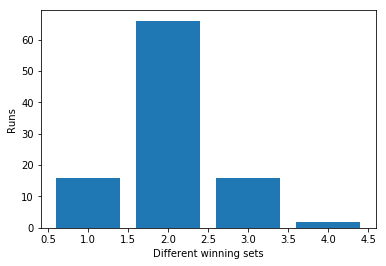

In [79]:
from collections import Counter
from matplotlib import pyplot as plt

winners = []
for i, row in df.iterrows():
    win = []
    for i in range(1,10):
        get = "k_" + str(i) + "_winners"
        win.append(int(row[get]))
    winners.append(win)
    
winner_sets = []
for i, result in enumerate(winners):
    winner_sets.append(len(set(result)))
    
c = Counter(winner_sets)
plt.bar(list(c.keys()), c.values())
plt.xlabel("Different winning sets")
plt.ylabel("Runs")
plt.show()